In [19]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, inspect
from sqlalchemy.orm import Session
from sqlalchemy.ext.automap import automap_base
from flask import Flask, jsonify


In [20]:
engine = create_engine('sqlite:////content/hawaii.sqlite')
connection = engine.connect()


In [21]:
# Reflect the tables into classes
Base = automap_base()
Base.prepare(engine, reflect=True)

<ipython-input-21-dc6a7d79ce87>:3: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [22]:
# Save references to the tables
Station = Base.classes.station
Measurement = Base.classes.measurement


In [23]:
# Create a session to link Python to the database
session = Session(bind=engine)

In [24]:
# Close the session at the end of the notebook
session.close()

In [26]:

# Perform Precipitation Analysis
# Query the most recent date in the dataset
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]


In [27]:

# Calculate the date one year ago from the most recent date
one_year_ago = pd.to_datetime(recent_date) - pd.DateOffset(years=1)


In [29]:
from datetime import datetime

# Calculate the date one year ago from the most recent date
one_year_ago = datetime.strftime(one_year_ago, '%Y-%m-%d')

# Create a query for the last year of data without passing the date as a variable
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).all()


In [30]:
# Save the query results to a Pandas DataFrame
precipitation_df = pd.DataFrame(precipitation_data, columns=['Date', 'Precipitation'])

In [31]:
# Sort the DataFrame by date
precipitation_df = precipitation_df.sort_values('Date')

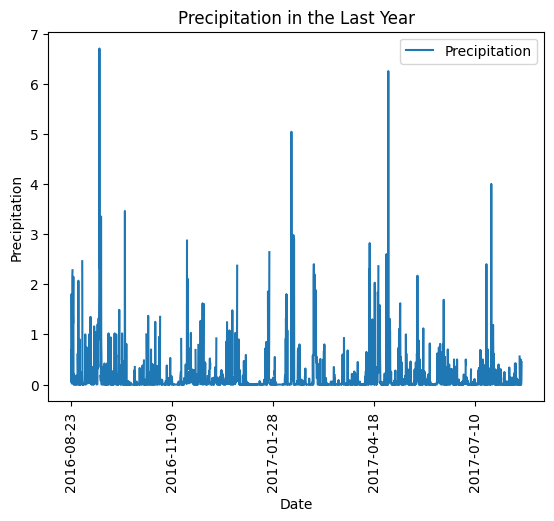

In [32]:
# Plot the results
precipitation_df.plot(x='Date', y='Precipitation', rot=90)
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.title('Precipitation in the Last Year')
plt.show()

In [33]:
# Print summary statistics for the precipitation data
summary_statistics = precipitation_df['Precipitation'].describe()
print(summary_statistics)

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


In [34]:
# Perform Station Analysis
# Query the number of stations in the dataset
num_stations = session.query(Station.station).count()
print(f"Number of Stations: {num_stations}")

Number of Stations: 9


In [35]:
# Query the stations and observation counts in descending order to find the most active station
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()


In [36]:
# Get the most active station
most_active_station = active_stations[0][0]
print(f"Most Active Station: {most_active_station}")

Most Active Station: USC00519281


In [37]:
# Query the min, max, and average temperatures for the most active station
temp_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).all()

In [38]:
# Print the temperature statistics
print(f"Temperature Statistics for the Most Active Station (Station ID: {most_active_station}):")
print(f"Minimum Temperature: {temp_stats[0][0]}")
print(f"Maximum Temperature: {temp_stats[0][1]}")
print(f"Average Temperature: {round(temp_stats[0][2], 2)}")

Temperature Statistics for the Most Active Station (Station ID: USC00519281):
Minimum Temperature: 54.0
Maximum Temperature: 85.0
Average Temperature: 71.66


In [39]:
# Set up Flask API
app = Flask(__name__)

In [40]:
@app.route("/")
def landing_page():
    return "Welcome to the API! Available routes: /api/precipitation, /api/stations, /api/tobs, /api/yyyy-mm-dd"


In [ ]:
@app.route("/api/precipitation")
def precipitation_api():
    # Create a query to retrieve the date and precipitation for the last year of